# Set 4: Stream crypto and randomness

This is the last set of **block cipher cryptography** challenges, and also our coverage of message authentication.

This set is **much easier** than the last set.  We introduce some new concepts, but the attacks themselves involve less code than, say, the CBC padding oracle.

Things get significantly trickier in the next two sets.  A lot of people drop off after set 4.

- [Preliminaries](#Preliminaries)
- [Challenge 25: Break "random access read/write" AES CTR](#Challenge-25:-Break-"random-access-read/write"-AES-CTR)
- [Challenge 26: CTR bitflipping](#Challenge-26:-CTR-bitflipping)
- [Challenge 27: Recover the key from CBC with IV=Key](#Challenge-27:-Recover-the-key-from-CBC-with-IV=Key)
- [Challenge 28: Implement a SHA-1 keyed MAC](#Challenge-28:-Implement-a-SHA-1-keyed-MAC)
- [Challenge 29: Break a SHA-1 keyed MAC using length extension](#Challenge-29:-Break-a-SHA-1-keyed-MAC-using-length-extension)
- [Challenge 30: Break an MD4 keyed MAC using length extension](#Challenge-30:-Break-an-MD4-keyed-MAC-using-length-extension)
- [Challenge 31: Implement and break HMAC-SHA1 with an artificial timing leak](#Challenge-31:-Implement-and-break-HMAC-SHA1-with-an-artificial-timing-leak)
- [Challenge 32: Break HMAC-SHA1 with a slightly less artificial timing leak](#Challenge-32:-Break-HMAC-SHA1-with-a-slightly-less-artificial-timing-leak)

## Preliminaries

A note on AES CTR mode: the method by which the block counter is combined with the nonce is not standardized, but may be implemented by any invertible function it seems.  [pyca/cryptography](https://cryptography.io/en/latest/) (i.e., OpenSSL) *adds* the block counter to a 16-byte, big-ending nonce value.  We follow cryptopals' method of *appending* an 8-byte, little-ending block counter to an 8-byte nonce.

In [1]:
import base64
import os.path
from random import randbytes

import pandas as pd
import matplotlib.pyplot as plt

# From pyca/cryptography
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

def xor(x, y):
    return bytes(xb^yb for xb, yb in zip(x, y))

mask32 = 0xFFFFFFFF

def lrot32(n, k):
    # Left rotate 32-bit integer k bits
    return ((n << k) | (n >> (32-k))) & mask32

def inv32(n):
    # Invert bits of 32-bit integer
    return ~n & mask32

def pad_pkcs7(text):
    padder = padding.PKCS7(128).padder()
    return padder.update(text) + padder.finalize()

def unpad_pkcs7(text):
    unpadder = padding.PKCS7(128).unpadder()
    return unpadder.update(text) + unpadder.finalize()

def aes_128_ecb_encrypt(ptext, key):
    # N.B.: performs no padding
    encryptor = Cipher(algorithms.AES128(key), modes.ECB()).encryptor()
    return encryptor.update(ptext) + encryptor.finalize()

def aes_128_ecb_decrypt(ctext, key):
    decryptor = Cipher(algorithms.AES128(key), modes.ECB()).decryptor()
    return unpad_pkcs7(decryptor.update(ctext) + decryptor.finalize())

def aes_128_cbc_encrypt(ptext, key, iv):
    encryptor = Cipher(algorithms.AES128(key), modes.CBC(iv)).encryptor()
    return encryptor.update(pad_pkcs7(ptext)) + encryptor.finalize()

def aes_128_cbc_decrypt(ctext, key, iv):
    decryptor = Cipher(algorithms.AES128(key), modes.CBC(iv)).decryptor()
    return unpad_pkcs7(decryptor.update(ctext) + decryptor.finalize())

def aes_128_ctr_crypt(text, key, nonce, offset=0):
    # Symmetric encryption/decryption
    n = (len(text)-1)//16+1
    stream = b"".join(
        aes_128_ecb_encrypt(nonce + int.to_bytes(i, 8, "little"), key)
        for i in range(offset, offset+n)
    )
    return xor(text, stream[:len(text)])

def A(n):
    return b"A"*n

def hamming_distance(x, y):
    # Distance between two strings in characters
    return sum(xc != yc for xc, yc in zip(x, y))

## Challenge 25: Break "random access read/write" AES CTR

Back to CTR.  Encrypt the recovered plaintext from [this file](https://cryptopals.com/static/challenge-data/25.txt) (the [ECB exercise](set-1.html#Challenge-7:-AES-in-ECB-mode)) under CTR with a random key (for this exercise the key should be unknown to you, but hold on to it).

Now, write the code that allows you to "seek" into the ciphertext, decrypt, and re-encrypt with different plaintext.  Expose this as a function, like, "_edit(ciphertext, key, offset, newtext)_".

Imagine the "edit" function was exposed to attackers by means of an API call that didn't reveal the key or the original plaintext; the attacker has the ciphertext and controls the offset and "new text".

Recover the original plaintext.

> **Food for thought.**
>
> A folkloric supposed benefit of CTR mode is the ability to easily "seek forward" into the ciphertext; to access byte N of the ciphertext, all you need to be able to do is generate byte N of the keystream.  Imagine if you'd relied on that advice to, say, encrypt a disk.

---

This attack fundamentally works because 1) the attacker is allowed to observe the ciphertext that results from supplying new plaintext; 2) the ciphertext is the product of simply XOR-ing the plaintext with a keystream; and 3) the keystream doesn't change.  Thus if the attacker supplies the ciphertext itself, then the original plaintext is returned.  I.e., if $C = P \oplus K$, then $C \oplus K = (P \oplus K) \oplus K = P$.  How the keystream is produced (CTR, PRNG, etc.) is immaterial.  Which makes one wonder, if CTR is a recommended mode, what *is* the means of encrypting disk blocks in a way that allows blocks to be randomly accessed and updated?

In [2]:
random_key = randbytes(16)
random_nonce = randbytes(8)

def edit(ctext, key, nonce, offset, new_text):
    # A subtle point: in CTR mode, the block structure effectively
    # disappears; the plaintext is simply being XOR-ed with a
    # keystream.  We need to refer to the block structure only to pick
    # up the correct position in the keystream.
    bn, bo = divmod(offset, 16)  # starting block number, intra-block offset
    new_ctext = aes_128_ctr_crypt(A(bo)+new_text, key, nonce, bn)[bo:]
    return ctext[:offset] + new_ctext + ctext[offset+len(new_text):]

def attack_edit(ctext, offset, new_text):
    return edit(ctext, random_key, random_nonce, offset, new_text)

ciphertext = aes_128_ctr_crypt(
    aes_128_ecb_decrypt(
        base64.b64decode(open("07.in").read()),
        b"YELLOW SUBMARINE"
    ),
    random_key,
    random_nonce
)

plaintext = attack_edit(ciphertext, 0, new_text=ciphertext)
print(plaintext.decode("ASCII").strip())

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can bet 
I can take a fly girl and make her wet. 


## Challenge 26: CTR bitflipping

There are people in the world that believe that CTR resists bit flipping attacks of the kind to which CBC mode is susceptible.

Re-implement [the CBC bitflipping exercise from earlier](set-2.html#Challenge-16:-CBC-bitflipping-attacks) to use CTR mode instead of CBC mode.  Inject an "admin=true" token.

---

Below is the same code we used before, using CTR instead.

In [3]:
prefix = b"comment1=cooking%20MCs;userdata="
suffix = b";comment2=%20like%20a%20pound%20of%20bacon"

def fun1(userdata):
    return aes_128_ctr_crypt(
        prefix + userdata.replace(b";", b"%3B").replace(b"=", b"%3D") + suffix,
        random_key,
        random_nonce
    )

def fun2(ctext):
    return (
        b";admin=true;" in aes_128_ctr_crypt(ctext, random_key, random_nonce)
    )

ciphertext = fun1(b"the ;admin=true; in this string will be quoted away")

print(fun2(ciphertext))

False


Well darned if this isn't even easier than for CBC mode.  Let $P_o$ and $C_o$ be the original plaintext and ciphertext, respectively, so that $C_o = P_o \oplus K$ where $K$ is the CTR keystream.  Let $P_n$ be the desired new text and define delta $D = P_o \oplus P_n$.  Then the required new ciphertext $C_n$ can be computed as $C_n = C_o \oplus D$, for $ C_o \oplus D = (P_o \oplus K) \oplus (P_o \oplus P_n) = P_n \oplus K$.

In [4]:
replacement_text = b";admin=true;"
n = len(replacement_text)
delta = xor(prefix[:n], replacement_text)
new_ciphertext = xor(ciphertext[:n], delta) + ciphertext[n:]
print(fun2(new_ciphertext))

True


## Challenge 27: Recover the key from CBC with IV=Key

Take your code from [the CBC exercise](set-2.html#Challenge-16:-CBC-bitflipping-attacks) and modify it so that it repurposes the key for CBC encryption as the IV.

Applications sometimes use the key as an IV on the auspices that both the sender and the receiver have to know the key already, and can save some space by using it as both a key and an IV.

Using the key as an IV is insecure; an attacker that can modify ciphertext in flight can get the receiver to decrypt a value that will reveal the key.

The CBC code from [exercise 16](set-2.html#Challenge-16:-CBC-bitflipping-attacks) encrypts a URL string.  Verify each byte of the plaintext for ASCII compliance (ie, look for high-ASCII values).  Noncompliant messages should raise an exception or return an error that includes the decrypted plaintext (this happens all the time in real systems, for what it's worth).

Use your code to encrypt a message that is at least 3 blocks long:

```
AES-CBC(P_1, P_2, P_3) -> C_1, C_2, C_3
```

Modify the message (you are now the attacker):

```
C_1, C_2, C_3 -> C_1, 0, C_1
```

Decrypt the message (you are now the receiver) and raise the appropriate error if high-ASCII is found.

As the attacker, recovering the plaintext from the error, extract the key:

```
P'_1 XOR P'_3
```

---

If $f^{-1}(C)$ is the AES decryption function (which implicitly utilizes the key), then CBC decryption of the first 3 blocks is given by

$$
\begin{eqnarray*}
P_1 &=& f^{-1}(C_1) \oplus IV \\
P_2 &=& f^{-1}(C_2) \oplus C_1 \\
P_3 &=& f^{-1}(C_3) \oplus C_2
\end{eqnarray*}
$$

If $C_2$ is set to $0$ and $C_3$ replaced with $C_1$, this reduces to

$$
\begin{eqnarray*}
P_1 &=& f^{-1}(C_1) \oplus IV \\
P_3 &=& f^{-1}(C_1)
\end{eqnarray*}
$$

and $P_1 \oplus P_3 = IV$.  And if the initialization vector repeats the key, then the key is thereby revealed.

In [5]:
def fun1(userdata):
    # Back to CBC mode
    return aes_128_cbc_encrypt(
        prefix + userdata.replace(b";", b"%3B").replace(b"=", b"%3D") + suffix,
        key=random_key,
        iv=random_key
    )

def fun3(ctext):
    ptext = aes_128_cbc_decrypt(ctext, key=random_key, iv=random_key)
    return (all(b < 128 for b in ptext), ptext)

ciphertext = bytearray(fun1(A(48)))
ciphertext[16:32] = bytes(16)
ciphertext[32:48] = ciphertext[:16]

is_valid, plaintext = fun3(bytes(ciphertext))
assert not is_valid

recovered_key = xor(plaintext[:16], plaintext[32:48])
recovered_key == random_key

True

## Challenge 28: Implement a SHA-1 keyed MAC

Find a SHA-1 implementation in the language you code in.

> **Don't cheat.  It won't work.**
>
> Do not use the SHA-1 implementation your language already provides (for instance, don't use the "Digest" library in Ruby, or call OpenSSL; in Ruby, you'd want a pure-Ruby SHA-1).

Write a function to authenticate a message under a secret key by using a secret-prefix MAC, which is simply:

```
SHA1(key || message)
```

Verify that you cannot tamper with the message without breaking the MAC you've produced, and that you can't produce a new MAC without knowing the secret key.

---

Our source for the algorithm is the pseudocode given in [Wikipedia](https://en.wikipedia.org/wiki/SHA-1).  The `starting_hash` and `starting_offset` arguments will be used in the next challenge.

In [6]:
def sha1(message, starting_hash=None, starting_offset=0):

    # Initialize hash
    if starting_hash != None:
        h0, h1, h2, h3, h4 = [
            int(starting_hash[i:i+8], 16) for i in range(0, 40, 8)
        ]
    else:
        h0 = 0x67452301
        h1 = 0xEFCDAB89
        h2 = 0x98BADCFE
        h3 = 0x10325476
        h4 = 0xC3D2E1F0

    # Pad message and append message length in bits (8 bytes,
    # big-endian) so that message is a multiple of 64 bytes in length
    oml = len(message)  # original message length
    n = 63 - (oml+8)%64
    message = message + b"\x80" + bytes(n) + int.to_bytes(oml*8, 8, "big")

    # For each chunk
    for i in range(starting_offset, len(message), 64):

        # Create 80-word "message schedule"
        w = [
            int.from_bytes(message[i+j:i+j+4], "big")
            for j in range(0, 64, 4)
        ]
        for j in range(16, 80):
            w.append(lrot32(w[j-3] ^ w[j-8] ^ w[j-14] ^ w[j-16], 1))

        # Initialize chunk hash from running hash
        a = h0
        b = h1
        c = h2
        d = h3
        e = h4

        # Mystery stuff
        for j in range(80):
            if j < 20:
                f = (b & c) | (inv32(b) & d)
                k = 0x5A827999
            elif 20 <= j < 40:
                f = b ^ c ^ d
                k = 0x6ED9EBA1
            elif 40 <= j < 60:
                f = (b & c) | (b & d) | (c & d)
                k = 0x8F1BBCDC
            else:
                f = b ^ c ^ d
                k = 0xCA62C1D6
            temp = (lrot32(a, 5) + f + e + k + w[j]) & mask32
            e = d
            d = c
            c = lrot32(b, 30)
            b = a
            a = temp

        # Add chunk hash back into running hash
        h0 = (h0 + a) & mask32
        h1 = (h1 + b) & mask32
        h2 = (h2 + c) & mask32
        h3 = (h3 + d) & mask32
        h4 = (h4 + e) & mask32

    return "%08x%08x%08x%08x%08x" % (h0, h1, h2, h3, h4)

# Show that the hashes are not just different, but very different

def hash_distance(message_1, message_2):
    return f"{hamming_distance(sha1(message_1), sha1(message_2))}/40"

print(hash_distance(random_key + b"message", random_key + b"MESSAGE"))
print(hash_distance(random_key + b"message", b"different key" + b"message"))
print(hash_distance(random_key + b"MESSAGE", b"different key" + b"message"))

38/40
39/40
37/40


## Challenge 29: Break a SHA-1 keyed MAC using length extension

Secret-prefix SHA-1 MACs are trivially breakable.

The attack on secret-prefix SHA-1 relies on the fact that you can take the ouput of SHA-1 and use it as a new starting point for SHA-1, thus taking an arbitrary SHA-1 hash and "feeding it more data".

Since the key precedes the data in secret-prefix, any additional data you feed the SHA-1 hash in this fashion will appear to have been hashed with the secret key.

To carry out the attack, you'll need to account for the fact that SHA-1 is "padded" with the bit-length of the message; your forged message will need to include that padding.  We call this "glue padding".  The final message you actually forge will be:

```
SHA1(key || original-message || glue-padding || new-message)
```

(where the final padding on the whole constructed message is implied)

Note that to generate the glue padding, you'll need to know the original bit length of the message; the message itself is known to the attacker, but the secret key isn't, so you'll need to guess at it.

This sounds more complicated than it is in practice.

To implement the attack, first write the function that computes the MD padding of an arbitrary message and verify that you're generating the same padding that your SHA-1 implementation is using.  This should take you 5-10 minutes.

Now, take the SHA-1 secret-prefix MAC of the message you want to forge --- this is just a SHA-1 hash --- and break it into 32 bit SHA-1 registers (SHA-1 calls them "a", "b", "c", &c).

Modify your SHA-1 implementation so that callers can pass in new values for "a", "b", "c" &c (they normally start at magic numbers).  With the registers "fixated", hash the additional data you want to forge.

Using this attack, generate a secret-prefix MAC under a secret key (choose a random word from /usr/share/dict/words or something) of the string:

```
"comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon"
```

Forge a variant of this message that ends with ";admin=true".

> **This is a very useful attack.**
>
> For instance: Thai Duong and Juliano Rizzo, who got to this attack before we did, used it to break the Flickr API.

---

So the idea is that we craft an attack message that is an extension of a valid message and, without knowing the key, craft a corresponding hash that matches the hash produced by hashing the attack message with the key.  In this way the server is fooled into thinking the attack message must be valid.  Below we take advantage that we know the length of the key, but generally it could just be guessed.

In [7]:
message = b"comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon"

# Recreate the padding added internally by SHA-1 (here we use
# knowledge of the length of the key)
oml = len(random_key) + len(message)
n = 63 - (oml+8)%64
padding = b"\x80" + bytes(n) + int.to_bytes(oml*8, 8, "big")

# Hash the original message (which includes hashing the padding) as
# would be done by the server and as would be returned to the client
h_original = sha1(random_key + message)

# The attack message
attack_message = message + padding + b";admin=true"

# Now craft a hash, knowing only the length of the key but not the key
# itself, by picking up where SHA-1 left off before
h_fake = sha1(
    A(len(random_key)) + attack_message,
    h_original,
    len(random_key)+len(message)+len(padding)
)

# Hash the attack message as would be done by the server and check,
# would we fool the server?
h_attack = sha1(random_key + attack_message)
h_fake == h_attack

True

## Challenge 30: Break an MD4 keyed MAC using length extension

Second verse, same as the first, but use MD4 instead of SHA-1.  Having done this attack once against SHA-1, the MD4 variant should take much less time; mostly just the time you'll spend Googling for an implementation of MD4.

> **You're thinking, why did we bother with this?**
>
> Blame Stripe.  In their second CTF game, the second-to-last challenge involved breaking an H(k, m) MAC with SHA-1.  Which meant that SHA-1 code was floating all over the Internet.  MD4 code, not so much.

---

MD4 is officially defined in [RFC 1320](https://datatracker.ietf.org/doc/html/rfc1320), but it has been deprecated for so long that it is indeed hard to find implementations.  Ours below is adapted from [this gist](https://gist.github.com/kangtastic/c3349fc4f9d659ee362b12d7d8c639b6).  The overall structure of the algorithm is identical to SHA-1 (padding, chunking, adding to a running hash) except that it uses little-endian byte order and of course the mysterious innards differ.

In [8]:
def md4(message, starting_hash=None, starting_offset=0):

    def F(x, y, z):
        return (x & y) | (inv32(x) & z)

    def G(x, y, z):
        return (x & y) | (x & z) | (y & z)

    def H(x, y, z):
        return x ^ y ^ z

    # Initialize hash
    if starting_hash != None:
        h = [
            int.from_bytes(bytes.fromhex(starting_hash[i:i+8]), "little")
            for i in range(0, 32, 8)
        ]
    else:
        h = [0x67452301, 0xEFCDAB89, 0x98BADCFE, 0x10325476]

    # Pad message and append message length in bits (8 bytes,
    # little-endian) so that message is a multiple of 64 bytes in
    # length
    oml = len(message)  # original message length
    n = 63 - (oml+8)%64
    message = message + b"\x80" + bytes(n) + int.to_bytes(oml*8, 8, "little")

    # For each chunk
    for i in range(starting_offset, len(message), 64):

        # Create 16-word block
        X = [
            int.from_bytes(message[i+j:i+j+4], "little")
            for j in range(0, 64, 4)
        ]

        # Initialize chunk hash from running hash
        ch = h.copy()

        # Round 1
        Xi = [3, 7, 11, 19]
        for n in range(16):
            i, j, k, l = map(lambda x: x%4, range(-n, -n+4))
            K = n
            S = Xi[n%4]
            hn = ch[i] + F(ch[j], ch[k], ch[l]) + X[K]
            ch[i] = lrot32(hn & mask32, S)

        # Round 2
        Xi = [3, 5, 9, 13]
        for n in range(16):
            i, j, k, l = map(lambda x: x%4, range(-n, -n+4))
            K = (n%4)*4 + n//4
            S = Xi[n%4]
            hn = ch[i] + G(ch[j], ch[k], ch[l]) + X[K] + 0x5A827999
            ch[i] = lrot32(hn & mask32, S)

        # Round 3
        Xi = [3, 9, 11, 15]
        Ki = [0, 8, 4, 12, 2, 10, 6, 14, 1, 9, 5, 13, 3, 11, 7, 15]
        for n in range(16):
            i, j, k, l = map(lambda x: x%4, range(-n, -n+4))
            K = Ki[n]
            S = Xi[n%4]
            hn = ch[i] + H(ch[j], ch[k], ch[l]) + X[K] + 0x6ED9EBA1
            ch[i] = lrot32(hn & mask32, S)

        # Add chunk hash back into running hash
        h = [(x + y) & mask32 for x, y in zip(h, ch)]

    return b"".join(int.to_bytes(x, 4, "little") for x in h).hex()

And as before...

In [9]:
message = b"comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon"

# Recreate the padding added internally by MD4 (here we use
# knowledge of the length of the key)
oml = len(random_key) + len(message)
n = 63 - (oml+8)%64
padding = b"\x80" + bytes(n) + int.to_bytes(oml*8, 8, "little")

# Hash the original message (which includes hashing the padding) as
# would be done by the server and as would be returned to the client
h_original = md4(random_key + message)

# The attack message
attack_message = message + padding + b";admin=true"

# Now craft a hash, knowing only the length of the key but not the key
# itself, by picking up where MD4 left off before
h_fake = md4(
    A(len(random_key)) + attack_message,
    h_original,
    len(random_key)+len(message)+len(padding)
)

# Hash the attack message as would be done by the server and check,
# would we fool the server?
h_attack = md4(random_key + attack_message)
h_fake == h_attack

True

## Challenge 31: Implement and break HMAC-SHA1 with an artificial timing leak

The psuedocode on Wikipedia should be enough.  HMAC is very easy.

Using the web framework of your choosing (Sinatra, web.py, whatever), write a tiny application that has a URL that takes a "file" argument and a "signature" argument, like so:

```
http://localhost:9000/test?file=foo&signature=46b4ec586117154dacd49d664e5d63fdc88efb51
```

Have the server generate an HMAC key, and then verify that the "signature" on incoming requests is valid for "file", using the "==" operator to compare the valid MAC for a file with the "signature" parameter (in other words, verify the HMAC the way any normal programmer would verify it).

Write a function, call it "insecure_compare", that implements the == operation by doing byte-at-a-time comparisons with early exit (ie, return false at the first non-matching byte).

In the loop for "insecure_compare", add a 50ms sleep (sleep 50ms after each byte).

Use your "insecure_compare" function to verify the HMACs on incoming requests, and test that the whole contraption works.  Return a 500 if the MAC is invalid, and a 200 if it's OK.

Using the timing leak in this application, write a program that discovers the valid MAC for any file.

> **Why artificial delays?**
>
> Early-exit string compares are probably the most common source of cryptographic timing leaks, but they aren't especially easy to exploit.  In fact, many timing leaks (for instance, any in C, C++, Ruby, or Python) probably aren't exploitable over a wide-area network at all.  To play with attacking real-world timing leaks, you have to start writing low-level timing code. We're keeping things cryptographic in these challenges.

---

We use differential timing to guess the signature, one hex digit at a time (this is assuming that the server performs comparisons on hex strings; if it compared binary bytes, then we would guess one byte at a time).  Trying each of the 16 possible hex digits for the first digit, the 15 of those guesses that are incorrect will terminate after a single comparison, while the one correct guess will result in 2 or more comparisons being performed by the server.  Thus, the correct first digit is the one with the singular longest comparison time.  We repeat this process iteratively up through the 39th digit; the 40th, last SHA-1 digit must simply be guessed since there is no 41st comparison to distinguish the correct guess by.

This technique relies on our ability to distinguish the time a single additional comparison takes.  As the problem notes, this is impossible in real code in the face of network latencies.  But to assess the possibility even in this contrived case where each comparison takes 50ms, we set up a local client and server and capture the distributions of total comparison times where the server makes between 1-10 comparisons (equivalently, where the leading 0-9 hex digits are correct).  As can be seen from the plot below, while there are some minor overlaps between total comparison times, statistically speaking the numbers of comparisons performed by the server are easily distinguished.

(N.B. Gathering the data takes about an hour, hence the use of a cached data file.)

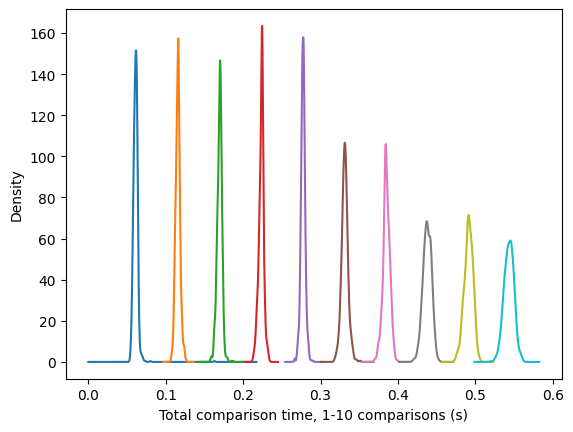

In [10]:
M = 10    # maximum number of comparisons to test
N = 1000  # sample size

if not os.path.exists("31-timing-data-50ms.csv"):

    # IMPORTS

    import csv
    from http.server import HTTPServer, BaseHTTPRequestHandler
    from threading import Thread
    from time import time, sleep
    from urllib.parse import urlparse, parse_qs

    import requests

    # SERVER

    delay = 50  # milliseconds

    class handler(BaseHTTPRequestHandler):

        def do_GET(self):
            url = urlparse(self.path)
            if url.path == "/test":
                s = parse_qs(url.query)["signature"][0]
                for c in s:
                    sleep(delay/1000)
                    if c != "A":
                        break
            elif url.path == "/exit":
                def shutdown():
                    sleep(1)
                    self.server.shutdown()
                Thread(target=shutdown).start()
            self.send_response(200)
            self.end_headers()

        def log_message(*args, **kwargs):
            pass

    Thread(
        target=lambda: HTTPServer(("", 8000), handler).serve_forever(),
        daemon=True
    ).start()

    # CLIENT

    with open("31-timing-data-50ms.csv", "w") as f:
        fw = csv.writer(f)
        fw.writerow(["num_correct_chars", "time"])
        for num_correct_chars in range(M):
            s = "A"*num_correct_chars + "B"*(40-num_correct_chars)
            for _ in range(N):
                start = time()
                requests.get(f"http://localhost:8000/test?signature={s}")
                elapsed = time() - start
                fw.writerow([num_correct_chars, elapsed])

    requests.get("http://localhost:8000/exit")

# Plot the data

df = pd.read_csv("31-timing-data-50ms.csv")

def plot_timing_data():
    for i in range(M):
        df[df.num_correct_chars == i].time.plot.kde()
    plt.xlabel(f"Total comparison time, 1-{M} comparisons (s)")
    plt.show()

plot_timing_data()

To quantify the above plot, we compute the probability $p$ (technically, maximum likelihood estimate) that the time to perform $n$ comparisons is strictly less than the time to perform $n+1$, and hence that the approach described above of distinguishing the number of comparisons performed by simple time comparison succeeds.  (This is computed by counting, for each observation of $n$ comparisons that took some time $t$, the number of observations of $n+1$ comparisons that took more than $t$.  If all the $n+1$ observations took more than $t$, then the probability for $n$ comparisons is 1.)  Since numbers of comparisons must be distinguished 39 times in a row for the overall process to be successful, the probability of overall success if given by $p^{39}$.

In [11]:
def print_timing_statistics(num_digits_guessed=1):
    df.sort_values("time", inplace=True)
    seen = [0]*M  # seen[n] = number of (n+1)-digit comparisons seen so far
    delta = num_digits_guessed
    s = 0
    for n in df.num_correct_chars:
        if n < M-delta:
            s += N - seen[n+delta]
            seen[n] += 1
    p_1 = s/((M-delta)*N*N)
    p_success = p_1**(40//delta-1)
    print(
        "P(can distinguish number of comparisons performed)",
        f"= {round(p_1*100, 3)}%"
    )
    print(f"P(overall success) = {round(p_success*100, 3)}%")

print_timing_statistics()

P(can distinguish number of comparisons performed) = 99.989%
P(overall success) = 99.568%


Thus with an artificial delay of 50ms per comparison, we are almost assured of guessing the signature.  Now for our solution.  In the proof-of-concept code below, we eschew actual timings and instead imagine that the server returns an indication of how long the comparison took in addition to the results of the comparison.

In [12]:
def hmac(key, message):
    def _sha1(message):
        return bytes.fromhex(sha1(message))
    if len(key) > 64:
        key = _sha1(key)
    if len(key) < 64:
        key = key + bytes(64-len(key))
    return sha1(xor(key, b"\x5c"*64) + _sha1(xor(key, b"\x36"*64) + message))

def insecure_compare(a, b):
    # Return length of matching prefix
    n = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            n += 1
        else:
            break
    return n

def verify_signature(file, signature):
    # Return (comparison time, result of comparison)
    n = insecure_compare(signature, hmac(random_key, file))
    return (n+1, n == len(signature))

file = b"foo"

signature = ["0"]*40  # signature that will be guessed digit by digit
for i in range(len(signature)):
    def probe(i, digit):
        signature[i] = digit
        time, is_correct = verify_signature(file, "".join(signature))
        return {"time": time, "is_correct": is_correct, "digit": digit}
    r = [probe(i, digit) for digit in "0123456789abcdef"]
    if any(t["is_correct"] for t in r):
        signature[i] = [t for t in r if t["is_correct"]][0]["digit"]
        break
    else:
        signature[i] = max(r, key=lambda t: t["time"])["digit"]

# Did we correctly guess the signature?
"".join(signature) == hmac(random_key, file)

True

## Challenge 32: Break HMAC-SHA1 with a slightly less artificial timing leak

Reduce the sleep in your "insecure_compare" until your previous solution breaks.  (Try 5ms to start.)

Now break it again.

---

Reducing the artificial comparison time to 1ms, we can see by the plot below how it becomes more difficult (though not impossible) to distinguish the number of comparisons performed.  (The data for this plot was obtained by running the timing code above, but setting `delay` to 1.)

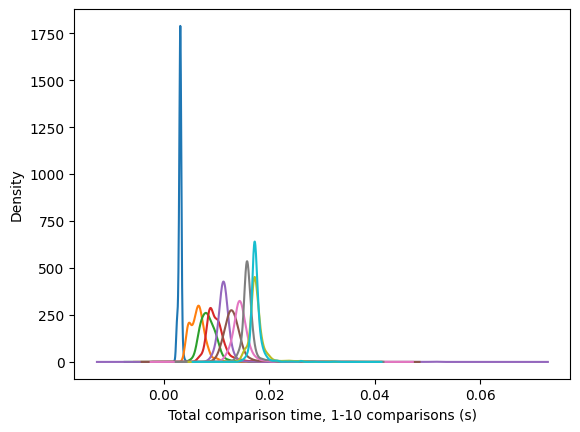

In [13]:
df = pd.read_csv("31-timing-data-1ms.csv")
plot_timing_data()

Statistically, the probability of correctly distinguishing the number of comparisons performed decreases, but particularly catastrophic is the effect on the probability of overall success:

In [14]:
print_timing_statistics()

P(can distinguish number of comparisons performed) = 85.977%
P(overall success) = 0.276%


But suppose we were to guess two hex digits at a time.  Then out of 256 possibilities, one guess causes the server to perform 3+ comparisons, 15 guesses perform 2 comparisons, and the remaining 240 guesses perform only 1 comparison.  If the 3+ and the 1-comparison cases are sufficiently distinguishable, then the probability of overall success rises.  (Note that, because we are guessing two digits at a time, we need repeat the process only 19 times, not 39.)

In [15]:
print_timing_statistics(num_digits_guessed=2)

P(can distinguish number of comparisons performed) = 96.387%
P(overall success) = 49.697%
